In [32]:
%pylab inline
%matplotlib inline
import pandas as pd
import sklearn

Populating the interactive namespace from numpy and matplotlib


In [4]:
print pd.version.short_version
print sklearn.__version__

0.15.2
0.15.2


# Restaurant Revenue Prediction

## ---- A Kaggle Competition

In this notebook, we'll try to tackle a Kaggle problem. The object is to predict annual restaurant sales based on objective measurements.

This is an interesting problem to me because it's set up in a classic regression setting. So all classic regression techniques should be applicable to the problem. The trick though, as like all machine learning problem, is to carefully test the various models and select the most generalizable one.

## Competition Description

With over 1,200 quick service restaurants across the globe, TFI is the company behind some of the world's most well-known brands: Burger King, Sbarro, Popeyes, Usta Donerci, and Arby’s. They employ over 20,000 people in Europe and Asia and make significant daily investments in developing new restaurant sites.

Right now, deciding when and where to open new restaurants is largely a subjective process based on the personal judgement and experience of development teams. This subjective data is difficult to accurately extrapolate across geographies and cultures. 

New restaurant sites take large investments of time and capital to get up and running. When the wrong location for a restaurant brand is chosen, the site closes within 18 months and operating losses are incurred. 

Finding a mathematical model to increase the effectiveness of investments in new restaurant sites would allow TFI to invest more in other important business areas, like sustainability, innovation, and training for new employees. Using demographic, real estate, and commercial data, this competition challenges you to predict the annual restaurant sales of 100,000 regional locations.

#Data Exploration

In [7]:
import pandas as pd
trainingdf = pd.read_csv('train.csv')
print trainingdf.columns

Index([u'Id', u'Open Date', u'City', u'City Group', u'Type', u'P1', u'P2', u'P3', u'P4', u'P5', u'P6', u'P7', u'P8', u'P9', u'P10', u'P11', u'P12', u'P13', u'P14', u'P15', u'P16', u'P17', u'P18', u'P19', u'P20', u'P21', u'P22', u'P23', u'P24', u'P25', u'P26', u'P27', u'P28', u'P29', u'P30', u'P31', u'P32', u'P33', u'P34', u'P35', u'P36', u'P37', u'revenue'], dtype='object')


convert date strings to days from the first restaurant opened

In [9]:
import datetime
opendate = trainingdf['Open Date']
dates = [datetime.datetime.strptime(date, '%m/%d/%Y') for date in opendate]
mindate = min(dates)
ageByDays = [(item-mindate).days for item in dates]
print ageByDays[:10]

[1165, 4299, 6149, 5748, 4749, 5028, 5269, 5522, 5225, 5670]


convert string categories to integer categories

In [11]:
import numpy as np
city = trainingdf['City']
b,c = np.unique(city, return_inverse=True)
print c[:10]
citygroup = trainingdf['City Group']
b,citygroupcat = np.unique(citygroup, return_inverse=True)
print citygroupcat[:10]
t = trainingdf['Type']
b,tcat = np.unique(t, return_inverse=True)
print tcat[:10]

[31  3 10 28 14  3 31 31  1 11]
[0 0 1 1 1 0 0 0 1 1]
[2 1 2 2 2 1 2 2 2 2]


In [26]:
trainingdf['Open Date'] = ageByDays
trainingdf['City'] = c
trainingdf['City Group'] = citygroupcat
trainingdf['Type'] = tcat
X_train = trainingdf[trainingdf.columns[1:-1]]
y_train = trainingdf['revenue']
print X_train.head()

   Open Date  City  City Group  Type  P1   P2  P3  P4  P5  P6 ...   P28  P29  \
0       1165    31           0     2   4  5.0   4   4   2   2 ...   2.0  3.0   
1       4299     3           0     1   4  5.0   4   4   1   2 ...   3.0  3.0   
2       6149    10           1     2   2  4.0   2   5   2   3 ...   1.0  3.0   
3       5748    28           1     2   6  4.5   6   6   4   4 ...   2.5  7.5   
4       4749    14           1     2   3  4.0   3   4   2   2 ...   1.0  3.0   

   P30  P31  P32  P33  P34  P35  P36  P37  
0    5    3    4    5    5    4    3    4  
1    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0  
3   25   12   10    6   18   12   12    6  
4    5    1    3    2    3    4    3    3  

[5 rows x 41 columns]


#First cut, linear regression

In [35]:
k = 5
features = []
columns = list(X_train.columns)
for i in range(k):
    rSquare = []
    for i in range(len(columns)):
        model = LinearRegression()
        X = X_train[X_train.columns[i]]
        f = pd.DataFrame(X_train, columns=features)
        f['newX'] = X
        model.fit(f, y_train)
        rscore = model.score(f, y_train)
        rSquare.append(rscore)
    feature = X_train.columns[np.argmax(map(abs,rSquare))]
    features.append(feature)
    columns.remove(feature)
print features

['Open Date', 'City', 'Type', 'City Group', 'P29']


In [36]:
import statsmodels.formula.api as sm
df = pd.DataFrame({'y':y_train, 'x':X_train['Open Date']})
result = sm.ols(formula="y ~ x", data = df).fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     16.03
Date:                Thu, 26 Mar 2015   Prob (F-statistic):           0.000102
Time:                        07:48:14   Log-Likelihood:                -2208.6
No. Observations:                 137   AIC:                             4421.
Df Residuals:                     135   BIC:                             4427.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   7.135e+06   7.02e+05     10.171      0.0

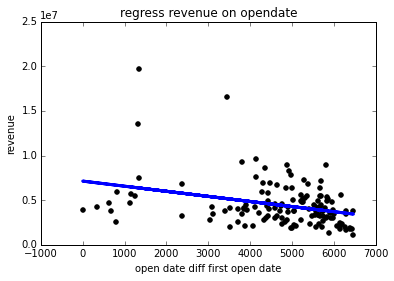

In [34]:
import matplotlib.pyplot as plt
model = LinearRegression()
X = standardize(X_train[feature1])
model.fit(X, standardize(y_train))
predy = model.predict(X) * y_train.std() + y_train.mean()
plt.scatter(X_train['Open Date'], y_train, color='black')
plt.plot(X_train['Open Date'], predy, color='blue', linewidth=3)
plt.title('regress revenue on opendate')
plt.xlabel('open date diff first open date')
plt.ylabel('revenue')

In [ ]:
# todo
# looks like P1-P37 can be represented by two or three variables by PCA
# and also column City has 37 categories, which also need to be classfied into two or three categories, 
# so that there are not so much dummy variables to be added
# select five features by forward stepwise selection(aic? bic? adjusted r square?)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
model = LinearRegression()
rfe = RFE(model, 5)
rfe = rfe.fit(X_train, y_train)
print rfe.support_
print rfe.ranking_

[False False False  True False False False False False  True False  True
  True False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
[37 28 29  1 17  8 25 11 26  1 36  1  1 21 15 22  1 16 19  5  4  6 24  9 14
 12 23  2 10  3 34  7 27 33 30 18 32 35 31 13 20]


Type, P6, P8, P9, P13